#  Semantic segmentation by Fully Convolutional DenseNet56 with Keras2.0

###  This is my experiment to see how Fully Convolutional DenseNet56 works with little data

For theory and algorithm. please refer to "The One Hundred Layers Tiramisu: Fully Convolutional DenseNets for Semantic Segmentation (Simon Jegou, Michal Drozdzal, David Vazquez, Adriana Romero, Yoshua Bengio),  5 Dec 2016" 
https://arxiv.org/abs/1611.09326

Origingal code in fast.ai by Jeremy Howard is provided with this link. I rewrite it with keras2 and modify https://github.com/fastai/courses/blob/master/deeplearning2/tiramisu-keras.ipynb 

For data, http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/
Segmentation and Recognition Using Structure from Motion Point Clouds, ECCV 2008 Brostow, Shotton, Fauqueur, Cipolla

In [1]:
pip uninstall -y keras

Found existing installation: Keras 2.0.6
Uninstalling Keras-2.0.6:
  Successfully uninstalled Keras-2.0.6
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install keras==2.0.6

  Using cached Keras-2.0.6-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip uninstall -y tensorflow

Found existing installation: tensorflow 1.15.0
Uninstalling tensorflow-1.15.0:
  Successfully uninstalled tensorflow-1.15.0
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tensorflow==1.15

  Using cached tensorflow-1.15.0-cp37-cp37m-macosx_10_11_x86_64.whl (124.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import h5py
import numpy as np
import tensorflow as tf
import time
import glob
import json
import csv
import bcolz
import threading
import random
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import keras
from keras import applications
from keras.preprocessing import image

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D,Cropping2D,BatchNormalization,Conv2DTranspose
from keras.layers import Activation, Dropout, Flatten, Dense, Lambda, GlobalAveragePooling2D, Reshape
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential

from keras.engine import Input
from keras.layers.merge import concatenate
from keras.layers.pooling import AveragePooling2D
from keras.regularizers import l2
from keras.utils import np_utils
from keras.optimizers import SGD

sess = tf.Session()
import keras.backend as K
K.set_session(sess)

Using TensorFlow backend.


## 1. Data preparation

CamVid., sciene-images data set, is used. 

In [6]:
PATH = os.path.join('data', 'camvid')
PATH

'data/camvid'

### 1.1  Read name of images

In [7]:
frames_path = os.path.join(PATH, '701_StillsRaw_full')
frames_path

'data/camvid/701_StillsRaw_full'

In [8]:
labels_path = os.path.join(PATH, 'LabeledApproved_full')
labels_path

'data/camvid/LabeledApproved_full'

In [9]:
fnames = glob.glob(os.path.join(frames_path, '*.png'))

In [10]:
lnames = [os.path.join(labels_path, os.path.basename(fn)[:-4] + '_L.png') for fn in fnames]

In [11]:
img_sz = (480,360)

In [12]:
def open_image(fn): return np.array(Image.open(fn).resize(img_sz, Image.NEAREST))

In [13]:
img = Image.open(fnames[0]).resize(img_sz, Image.NEAREST)

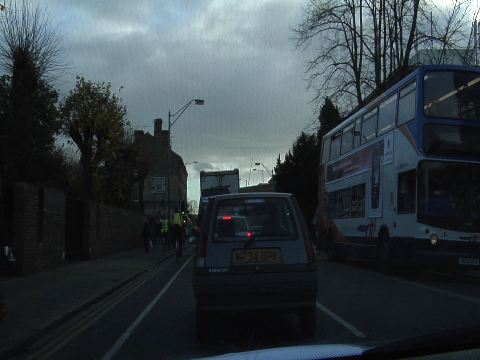

In [14]:
img

### 1.2 Load images

In [15]:
imgs = np.stack([open_image(fn) for fn in fnames])

In [16]:
labels = np.stack([open_image(fn) for fn in lnames])

In [17]:
imgs.shape, labels.shape

((701, 360, 480, 3), (701, 360, 480, 3))

### 1.3 Save array 

In [18]:
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname): return bcolz.open(fname)[:]

In [19]:
#Normalize pixel values
imgs = imgs/255.

In [20]:
save_array(os.path.join(PATH, 'results', 'imgs.bc'), imgs)
save_array(os.path.join(PATH, 'results', 'labels.bc'), labels)

In [21]:
imgs = load_array(os.path.join(PATH, 'results', 'imgs.bc'))
labels = load_array(os.path.join(PATH, 'results', 'labels.bc'))

### 1.4 Standardize values of image data

In [22]:
av = np.mean(imgs)
sd = np.std(imgs)
av, sd

(0.39996644266361026, 0.3017949114229098)

In [23]:
imgs -= av
imgs /= sd

In [24]:
n, r, c, ch = imgs.shape

## 2.Data Preprocessing

### 2.1 Data generator

This implementation employs data augmentation on CamVid. 

Augmentation includes random cropping / horizontal flipping, as done by `segm_generator()`. `BatchIndices()` lets us randomly sample batches from input array.

In [25]:
class BatchIndices(object):
    def __init__(self, n, bs, shuffle=False):
        self.n,self.bs,self.shuffle = n,bs,shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res

In [26]:
bi = BatchIndices(10,3)
[next(bi) for o in range(5)]

[array([0, 1, 2]),
 array([3, 4, 5]),
 array([6, 7, 8]),
 array([9]),
 array([0, 1, 2])]

In [27]:
bi = BatchIndices(10,3,True)
[next(bi) for o in range(5)]

[array([9, 5, 6]),
 array([7, 1, 3]),
 array([8, 2, 0]),
 array([4]),
 array([2, 5, 7])]

In [28]:
class segm_generator(object):
    def __init__(self, x, y, bs=64, out_sz=(224,224), train=True):
        self.x, self.y, self.bs, self.train = x,y,bs,train
        self.n, self.ri, self.ci, _ = x.shape
        self.idx_gen = BatchIndices(self.n, bs, train)
        self.ro, self.co = out_sz
        self.ych = self.y.shape[-1] if len(y.shape)==4 else 1

    def get_slice(self, i,o):
        start = random.randint(0, i-o) if self.train else (i-o)
        return slice(start, start+o)

    def get_item(self, idx):
        slice_r = self.get_slice(self.ri, self.ro)
        slice_c = self.get_slice(self.ci, self.co)
        x = self.x[idx, slice_r, slice_c]
        y = self.y[idx, slice_r, slice_c]
        if self.train and (random.random()>0.5): 
            y = y[:,::-1]
            x = x[:,::-1]
        return x, y

    def __next__(self):
        idxs = next(self.idx_gen)
        items = (self.get_item(idx) for idx in idxs)
        xs,ys = zip(*items)
        return np.stack(xs), np.stack(ys).reshape(len(ys), -1, self.ych)

As an example, here's a crop of the image.

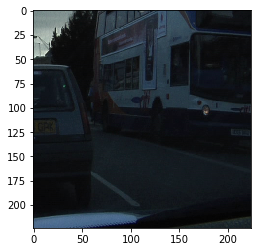

In [29]:
sg = segm_generator(imgs, labels, 4, train=False)
b_img, b_label = next(sg)
plt.imshow(b_img[0]*0.3+0.4);

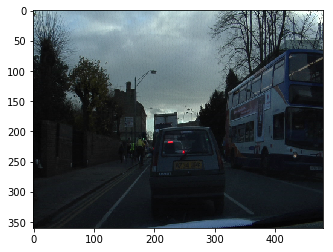

In [30]:
plt.imshow(imgs[0]*0.3+0.4);

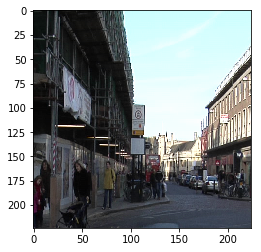

In [31]:
sg = segm_generator(imgs, labels, 4, train=True)
b_img, b_label = next(sg)
plt.imshow(b_img[0]*0.3+0.4);

### 2.2 Convert labels

The following loads, parses, and converts the segment labels we need for targets.

In particular we're looking to make the segmented targets into integers for classification purposes.

Each segment / category is indicated by a particular color. The following maps each unique pixel to it's category.

In [32]:
for l in open(os.path.join(PATH, "label_colors.txt")):
    aa = l[:-1].split("\t")
    a = aa[0]
    b = aa[1]
    print(aa)

['64 128 64', 'Animal']
['192 0 128', 'Archway']
['0 128 192', 'Bicyclist']
['0 128 64', 'Bridge']
['128 0 0', 'Building']
['64 0 128', 'Car']
['64 0 192', 'CartLuggagePram']
['192 128 64', 'Child']
['192 192 128', 'Column_Pole']
['64 64 128', 'Fence']
['128 0 192', 'LaneMkgsDriv']
['192 0 64', 'LaneMkgsNonDriv']
['128 128 64', 'Misc_Text']
['192 0 192', 'MotorcycleScooter']
['128 64 64', 'OtherMoving']
['64 192 128', 'ParkingBlock']
['64 64 0', 'Pedestrian']
['128 64 128', 'Road']
['128 128 192', 'RoadShoulder']
['0 0 192', 'Sidewalk']
['192 128 128', 'SignSymbol']
['128 128 128', 'Sky']
['64 128 192', 'SUVPickupTruck']
['0 0 64', 'TrafficCone']
['0 64 64', 'TrafficLight']
['192 64 128', 'Train']
['128 128 0', 'Tree']
['192 128 192', 'Truck_Bus']
['64 0 64', 'Tunnel']
['192 192 0', 'VegetationMisc']
['0 0 0', 'Void']
['64 192 0', 'Wall']


In [33]:
def parse_code(l):
    a,b = l.strip().split("\t")
    return tuple(int(o) for o in a.split(' ')), b

In [34]:
label_codes, label_names = zip(*[parse_code(l) for l in open(os.path.join(PATH, "label_colors.txt"))])

In [35]:
label_codes, label_names = list(label_codes),list(label_names)

In [36]:
list(zip(label_codes,label_names))[:5]

[((64, 128, 64), 'Animal'),
 ((192, 0, 128), 'Archway'),
 ((0, 128, 192), 'Bicyclist'),
 ((0, 128, 64), 'Bridge'),
 ((128, 0, 0), 'Building')]

We're going to map each unique pixel color to an integer so we can classify w/ our NN

In [37]:
code2id = {v:k for k,v in enumerate(label_codes)}

We'll include an integer for erroneous pixel values.

In [38]:
failed_code = len(label_codes) + 1

In [39]:
label_codes.append((0,0,0))
label_names.append('unk')

In [40]:
def conv_one_label(i): 
    res = np.zeros((r,c), 'uint8')
    for j in range(r): 
        for k in range(c):
            try: res[j,k] = code2id[tuple(labels[i,j,k])]
            except: res[j,k] = failed_code
    return res

In [41]:
from concurrent.futures import ProcessPoolExecutor

In [42]:
def conv_all_labels():
    ex = ProcessPoolExecutor(8)
    return np.stack(ex.map(conv_one_label, range(n)))

Now we'll create integer-mapped labels for all our colored images.

In [43]:
%time labels_int = conv_all_labels()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/magics/execution.py:1321: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code, glob, local_ns)


CPU times: user 551 ms, sys: 316 ms, total: 867 ms
Wall time: 5min 12s


In [44]:
np.count_nonzero(labels_int == failed_code)

44

Set erroneous pixels to zero.

In [45]:
labels_int.shape

(701, 360, 480)

In [46]:
labels_int[labels_int == failed_code] = 0

In [47]:
save_array(os.path.join(PATH, 'results', 'labels_int.bc'), labels_int)

In [48]:
labels_int = load_array(os.path.join(PATH, 'results', 'labels_int.bc'))

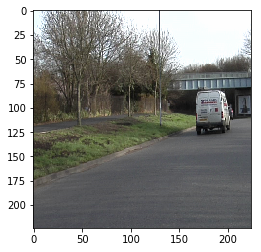

In [49]:
sg = segm_generator(imgs, labels, 4, train=True)
b_img, b_label = next(sg)
plt.imshow(b_img[0] * 0.3 + 0.4);

Here is an example of how the segmented image looks.

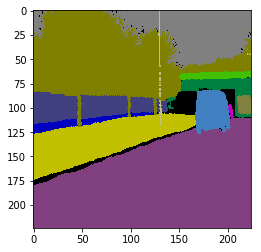

In [50]:
plt.imshow(b_label[0].reshape(224,224,3));

### 2.3 Split training set and test set

Next we load test set, set training/test images and labels.

In [51]:
trn = imgs[0:468]
trn_labels = labels_int[0:468]
test = imgs[468:701]
test_labels = labels_int[468:701]
trn.shape, trn_labels.shape, test.shape, test_labels.shape

((468, 360, 480, 3), (468, 360, 480), (233, 360, 480, 3), (233, 360, 480))

In [52]:
rnd_trn = len(trn_labels)
rnd_test = len(test_labels)

## 3. Build "Fully Convolutional DenseNet56 "

### 3.1 Helper functions

In [53]:
def relu(x): return Activation('relu')(x)
def dropout(x, p): return Dropout(p)(x) if p else x
def bn(x): return BatchNormalization( axis=-1)(x)
def relu_bn(x): return relu(bn(x))
def concat(xs): return concatenate(xs, axis=-1)

In [54]:
def conv(x, nf, sz, wd, p, stride=1): 
    x = Conv2D(nf, sz, kernel_initializer='he_uniform', padding='same', 
                      strides=(stride,stride), kernel_regularizer=l2(wd))(x)
    return dropout(x, p)

def conv_relu_bn(x, nf, sz=3, wd=0, p=0, stride=1): 
    return conv(relu_bn(x), nf, sz, wd=wd, p=p, stride=stride)

Recall the dense block from DenseNet.

In [55]:
def dense_block(n,x,growth_rate,p,wd):
    added = []
    for i in range(n):
        b = conv_relu_bn(x, growth_rate, p=p, wd=wd)
        x = concat([x, b])
        added.append(b)
    return x,added

This is the downsampling transition. 

In the original paper, downsampling consists of 1x1 convolution followed by max pooling. However we've found a stride 2 1x1 convolution to give better results.

In [56]:
def transition_dn(x, p, wd):
#     x = conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd)
#     return MaxPooling2D(strides=(2, 2))(x)
    return conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd, stride=2)

Next we build the entire downward path, keeping track of Dense block outputs in a list called `skip`. 

In [57]:
def down_path(x, nb_layers, growth_rate, p, wd):
    skips = []
    for i,n in enumerate(nb_layers):
        x,added = dense_block(n,x,growth_rate,p,wd)
        skips.append(x)
        x = transition_dn(x, p=p, wd=wd)
    return skips, added

This is the upsampling transition. We use a transpose convolution layer.

In [58]:
def transition_up(added, wd=0):
    x = concat(added)
    _,r,c,ch = x.get_shape().as_list()
    return Conv2DTranspose(ch, 3,  kernel_initializer='he_uniform', 
               padding='same', strides=(2,2), kernel_regularizer=l2(wd))(x)
#     x = UpSampling2D()(x)
#     return conv(x, ch, 2, wd, 0)

This builds our upward path, concatenating the skip connections from `skip` to the Dense block inputs.

In [59]:
def up_path(added, skips, nb_layers, growth_rate, p, wd):
    for i,n in enumerate(nb_layers):
        x = transition_up(added, wd)
        x = concat([x,skips[i]])
        x,added = dense_block(n,x,growth_rate,p,wd)
    return x

### 3.2 Build the model

- nb_classes: number of classes
- img_input: tuple of shape (channels, rows, columns) or (rows, columns, channels)
- nb_dense_block: number of dense blocks to add 
- growth_rate: number of filters to add per dense block
- nb_filter:  initial number of filters
- nb_layers_per_block: number of layers in each dense block.
  - If positive integer, a set number of layers per dense block.
  - If list, nb_layer is used as provided
- p: dropout rate
- wd: weight decay

In [60]:
def reverse(a): return list(reversed(a))

Finally we put together the entire network.

In [61]:
def create_tiramisu(nb_classes, img_input, nb_dense_block=6, 
    growth_rate=12, nb_filter=48, nb_layers_per_block=4, p=None, wd=0):
    
    if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
        nb_layers = list(nb_layers_per_block)
    else: nb_layers = [nb_layers_per_block] * nb_dense_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    skips,added = down_path(x, nb_layers, growth_rate, p, wd)
    x = up_path(added, reverse(skips[:-1]), reverse(nb_layers[:-1]), growth_rate, p, wd)
    
    x = conv(x, nb_classes, 1, wd, 0)
    _,r,c,f = x.get_shape().as_list()
    x = Reshape((-1, nb_classes))(x)
    return Activation('softmax')(x)

## 4. Train the model

### 4.1 Training on argumented images

In [65]:
input_shape = (224,224,3)

In [66]:
img_input = Input(shape = input_shape)

In [67]:
x = create_tiramisu(33, img_input, nb_layers_per_block = 4, p = 0.2, wd = 1e-4)


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [83]:
model = Model(img_input, x)

In [84]:
gen = segm_generator(trn, trn_labels, 3, train = True)

In [85]:
gen_test = segm_generator(test, test_labels, 3, train = False)

In [86]:
model.compile(loss = 'sparse_categorical_crossentropy',  optimizer = keras.optimizers.RMSprop(1e-3), metrics = ["accuracy"])

filepath = 'tiramisu.{epoch:02d}-{val_acc:.2f}.hdf5'
mc_cb = keras.callbacks.ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'max')

In [87]:
model.optimizer = keras.optimizers.RMSprop(1e-3, decay=1-0.99995)

To obtain accuracy over 85%,  it may take more than 24-48 hours (50-100 epochs) when you use Mac air (without GPU)
Please look at http://www.toshistats.net/deep-learning-blog/2017/8/12/this-is-incredible-semantic-segmentation-by-just-700-images-from-scratch-with-mac-air

Epoch 1/50
Epoch 00000: val_acc improved from -inf to 0.67126, saving model to tiramisu.00-0.67.hdf5
550s - loss: 1.9434 - acc: 0.5387 - val_loss: 1.5818 - val_acc: 0.6713
Epoch 2/50
Epoch 00001: val_acc did not improve
529s - loss: 1.7801 - acc: 0.5541 - val_loss: 1.7563 - val_acc: 0.6374
Epoch 3/50
Epoch 00002: val_acc did not improve
526s - loss: 1.6416 - acc: 0.5789 - val_loss: 1.6212 - val_acc: 0.6558
Epoch 4/50
Epoch 00003: val_acc did not improve
526s - loss: 1.7423 - acc: 0.5474 - val_loss: 1.4737 - val_acc: 0.6371
Epoch 5/50
Epoch 00004: val_acc did not improve
521s - loss: 1.5972 - acc: 0.5822 - val_loss: 1.4367 - val_acc: 0.6582
Epoch 6/50
Epoch 00005: val_acc did not improve
523s - loss: 1.5496 - acc: 0.5872 - val_loss: 1.7244 - val_acc: 0.6260
Epoch 7/50
Epoch 00006: val_acc improved from 0.67126 to 0.69669, saving model to tiramisu.06-0.70.hdf5
525s - loss: 1.4806 - acc: 0.5982 - val_loss: 1.3721 - val_acc: 0.6967
Epoch 8/50
Epoch 00007: val_acc improved from 0.69669 to 0

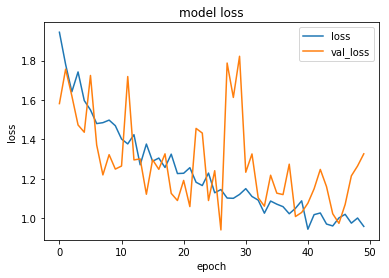

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 224, 224, 48)  1344        input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 224, 224, 48)  192         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 224, 224, 48)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

batch_normalization_33 (BatchNor (None, 14, 14, 360)   1440        concatenate_28[0][0]             
____________________________________________________________________________________________________
activation_33 (Activation)       (None, 14, 14, 360)   0           batch_normalization_33[0][0]     
____________________________________________________________________________________________________
conv2d_34 (Conv2D)               (None, 14, 14, 12)    38892       activation_33[0][0]              
____________________________________________________________________________________________________
dropout_33 (Dropout)             (None, 14, 14, 12)    0           conv2d_34[0][0]                  
____________________________________________________________________________________________________
concatenate_29 (Concatenate)     (None, 14, 14, 372)   0           concatenate_28[0][0]             
                                                                   dropout_33[0][0]        

In [91]:
batch_size = 10
epochs = 50

import time
t = time.time()  

# fit_generator
%time history = model.fit_generator(gen, rnd_trn // batch_size,  epochs, verbose = 2, validation_data = gen_test, validation_steps = rnd_test // batch_size, callbacks = [mc_cb])

t2 = time.time()
print(round(t2 - t, 5), 'Seconds to predict')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

model.summary()

## 5. View results

### 5.1 Import RGB data and names for each class

In [62]:
colors = [(64, 128, 64), (192, 0, 128), (0, 128, 192),(0, 128, 64), (128, 0, 0), (64, 0, 128), (64, 0, 192), (192, 128, 64), (192, 192, 128), (64, 64, 128),
 (128, 0, 192), (192, 0, 64), (128, 128, 64), (192, 0, 192), (128, 64, 64), (64, 192, 128), (64, 64, 0), (128, 64, 128), (128, 128, 192), (0, 0, 192),
(192, 128, 128), (128, 128, 128), (64, 128, 192), (0, 0, 64),(0 ,64, 64), (192, 64, 128), (128, 128, 0), (192, 128, 192), (64, 0, 64),(192, 192, 0),
 (0, 0, 0), (64, 192, 0)]

names = ['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car','CartLuggagePram', 'Child', 'Column_Pole','Fence', 'LaneMkgsDriv', 
         'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving','ParkingBlock','Pedestrian','Road', 'RoadShoulder','RoadShoulder',
         'Sidewalk', 'SignSymbol','Sky', 'SUVPickupTruck','TrafficCone', 'TrafficLight','Train','Tree','Truck_Bus', 'Tunnel','VegetationMisc','Void',
         'Wall']

In [63]:
# Import the model created above
from keras.models import load_model
model = load_model('tiramisu.26-0.79.hdf5')



Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




### 5.2 view the result of examples

In [64]:
i = 3

In [65]:
b = np.expand_dims(b_img[i], axis=0)
print(np.shape(b))

p = model.predict(b)
print(np.shape(p))

p = np.argmax(p[0],-1).reshape(224,224)
print(np.shape(p))

(1, 224, 224, 3)
(1, 50176, 33)
(224, 224)


In [66]:
def color_label(i): 
    res = np.zeros((r,c,3), 'uint8')
    for j in range(r): 
        for k in range(c):
            res[j,k,:] = colors[p[j,k]]
    return res

In [67]:
r = 224
c = 224
pred = color_label(p)

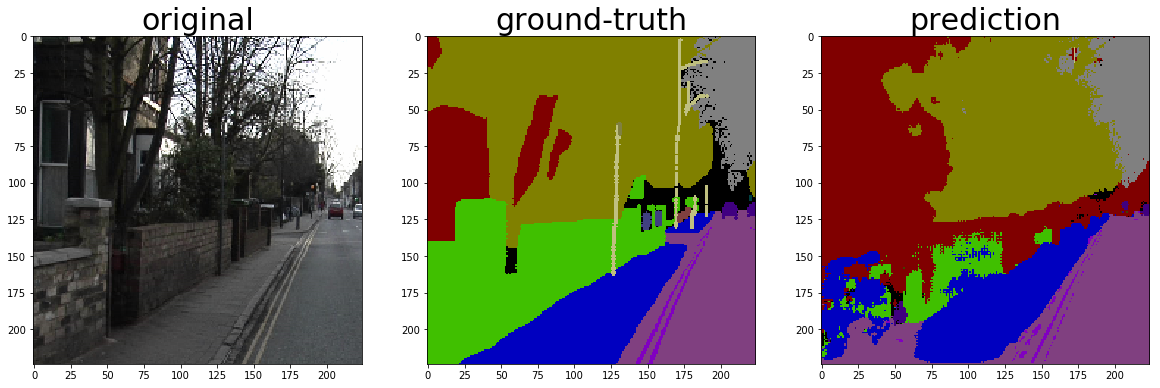

In [68]:
# Show the sample images
bl = b_label[i].reshape(224, 224, 3)

imm = [(b_img[i]*0.3+0.4), bl, pred]
title = ['original','ground-truth','prediction']
plt.figure(figsize = (20,15))

for i in range(len(imm)):
    plt.subplot(1,3, i+1)
    plt.imshow(imm[i]) 
    plt.title(title[i], fontsize=30)

Notice: TOSHI STATS SDN. BHD. and I do not accept any responsibility or liability for loss or damage occasioned to any person or property through using materials, instructions, methods, algorithm or ideas contained herein, or acting or refraining from acting as a result of such use. TOSHI STATS SDN. BHD. and I expressly disclaim all implied warranties, including merchantability or fitness for any particular purpose. There will be no duty on TOSHI STATS SDN. BHD. and me to correct any errors or defects in the codes and the software

## 6. Run on Sequence

In [69]:
colors = [(64, 128, 64), (192, 0, 128), (0, 128, 192),(0, 128, 64), (128, 0, 0), (64, 0, 128), (64, 0, 192), (192, 128, 64), (192, 192, 128), (64, 64, 128),
 (128, 0, 192), (192, 0, 64), (128, 128, 64), (192, 0, 192), (128, 64, 64), (64, 192, 128), (64, 64, 0), (128, 64, 128), (128, 128, 192), (0, 0, 192),
(192, 128, 128), (128, 128, 128), (64, 128, 192), (0, 0, 64),(0 ,64, 64), (192, 64, 128), (128, 128, 0), (192, 128, 192), (64, 0, 64),(192, 192, 0),
 (0, 0, 0), (64, 192, 0)]

names = ['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car','CartLuggagePram', 'Child', 'Column_Pole','Fence', 'LaneMkgsDriv', 
         'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving','ParkingBlock','Pedestrian','Road', 'RoadShoulder','RoadShoulder',
         'Sidewalk', 'SignSymbol','Sky', 'SUVPickupTruck','TrafficCone', 'TrafficLight','Train','Tree','Truck_Bus', 'Tunnel','VegetationMisc','Void',
         'Wall']

In [70]:
# Import the model created above
from keras.models import load_model

model = load_model('tiramisu.26-0.79.hdf5')

In [197]:
# Bring in images to predict
from tqdm import tqdm

PATH = os.path.join('data', 'camvid')
frames_path = os.path.join(PATH, '701_StillsRaw_full')
fnames = glob.glob(os.path.join(frames_path, '*.png'))
fnames.sort()

img_sz = (480,360)
def open_image(fn): 
    return np.array(Image.open(fn).resize(img_sz, Image.NEAREST))

imgs = []
for fname in tqdm(fnames, desc="Loading images"):
    imgs.append(Image.open(fname).resize(img_sz, Image.NEAREST))
len(imgs)

Loading images: 100%|██████████| 701/701 [00:26<00:00, 26.85it/s]


701

In [198]:
# Preprocess images before running through model
resized = []
for img in tqdm(imgs, desc="Resizing images"):
    resized.append(img.resize((224, 224)))
    
expanded = []
for img in tqdm(resized, desc="Expanding dims"):
    expanded.append(np.expand_dims(img, axis=0))

Expanding dims: 100%|██████████| 701/701 [00:00<00:00, 5678.96it/s]


In [213]:
# Get model predictions
preds = []
for img in tqdm(expanded, desc="Getting predictions"):
    pred = model.predict(img)
    pred = np.argmax(pred[0],-1).reshape(224,224)
    preds.append(pred)

Getting predictions: 100%|██████████| 701/701 [11:25<00:00,  1.02it/s]


In [214]:
# Create color labels

def color_label(p): 
    res = np.zeros((r,c,3), 'uint8')
    for j in range(r): 
        for k in range(c):
            res[j,k,:] = colors[p[j,k]]
    return res

r = 224
c = 224

color_labels = []
for pred in tqdm(preds, desc="Coloring labels"):
    color_labels.append(color_label(pred))

Coloring labels: 100%|██████████| 701/701 [00:33<00:00, 20.93it/s]


In [245]:
# Create overlays
overlays = []

for i in tqdm(range(len(imgs)), desc="Creating overlays"):
    bg = Image.fromarray(expanded[i][0]).convert("RGBA")
    ov = Image.fromarray(color_labels[i]).convert("RGBA")
    overlay = Image.blend(bg, ov, 0.7)
    overlays.append(overlay)

Creating overlays: 100%|██████████| 701/701 [00:00<00:00, 1347.53it/s]


In [246]:
# Save results as images
save_path = os.path.join(PATH, 'results_701_Stills_Raw_full')

for i in tqdm(range(len(imgs)), desc="Saving results"):
    fname = os.path.join(save_path, os.path.basename(fnames[i])[:-4] + "_res" + ".png")
    overlays[i].save(fname, "PNG")

Saving results: 100%|██████████| 701/701 [00:31<00:00, 22.50it/s]


In [266]:
# Save results as video
import cv2

img_height = 512
img_width = 1024

fourcc = cv2.VideoWriter_fourcc("M", "J", "P", "G")
out = cv2.VideoWriter(os.path.join(save_path, "camvid.avi"), fourcc,
            20.0, (img_width, img_height))

frame_names = sorted(os.listdir(save_path))
for step, frame_name in enumerate(frame_names):
    if step % 100 == 0:
        print(step)

    if ".png" in frame_name:
        frame_path = os.path.join(save_path, frame_name)
        frame = cv2.imread(frame_path, -1)
        frame = cv2.resize(frame, (img_width, img_height))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGRA2BGR)
        
        out.write(frame)

0
100
200
300
400
500
600
700


## 7. Run on CityScapes Sequence

In [58]:
colors = [(64, 128, 64), (192, 0, 128), (0, 128, 192),(0, 128, 64), (128, 0, 0), (64, 0, 128), (64, 0, 192), (192, 128, 64), (192, 192, 128), (64, 64, 128),
 (128, 0, 192), (192, 0, 64), (128, 128, 64), (192, 0, 192), (128, 64, 64), (64, 192, 128), (64, 64, 0), (128, 64, 128), (128, 128, 192), (0, 0, 192),
(192, 128, 128), (128, 128, 128), (64, 128, 192), (0, 0, 64),(0 ,64, 64), (192, 64, 128), (128, 128, 0), (192, 128, 192), (64, 0, 64),(192, 192, 0),
 (0, 0, 0), (64, 192, 0)]

names = ['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car','CartLuggagePram', 'Child', 'Column_Pole','Fence', 'LaneMkgsDriv', 
         'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving','ParkingBlock','Pedestrian','Road', 'RoadShoulder','RoadShoulder',
         'Sidewalk', 'SignSymbol','Sky', 'SUVPickupTruck','TrafficCone', 'TrafficLight','Train','Tree','Truck_Bus', 'Tunnel','VegetationMisc','Void',
         'Wall']

In [59]:
# Import the model created above
from keras.models import load_model

model = load_model('tiramisu.26-0.79.hdf5')



Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




In [60]:
# Bring in images to predict
from tqdm import tqdm

PATH = os.path.join('data', 'cityscapes')
frames_path = os.path.join(PATH, 'stuttgart_02')
fnames = glob.glob(os.path.join(frames_path, '*.png'))
fnames.sort()

img_sz = (480,360)
def open_image(fn): 
    return np.array(Image.open(fn).resize(img_sz, Image.NEAREST))

imgs = []
for fname in tqdm(fnames, desc="Loading images"):
    imgs.append(Image.open(fname).resize(img_sz, Image.NEAREST))
len(imgs)

Loading images: 100%|██████████| 1200/1200 [02:22<00:00,  8.41it/s]


1200

In [61]:
# Preprocess images before running through model
resized = []
for img in tqdm(imgs, desc="Resizing images"):
    resized.append(img.resize((224, 224)))
    
expanded = []
for img in tqdm(resized, desc="Expanding dims"):
    expanded.append(np.expand_dims(img, axis=0))

Expanding dims: 100%|██████████| 1200/1200 [00:00<00:00, 6279.58it/s]


In [62]:
# Get model predictions
preds = []
for img in tqdm(expanded, desc="Getting predictions"):
    pred = model.predict(img)
    pred = np.argmax(pred[0],-1).reshape(224,224)
    preds.append(pred)

Getting predictions: 100%|██████████| 1200/1200 [15:16<00:00,  1.31it/s]


In [63]:
# Create color labels

def color_label(p): 
    res = np.zeros((r,c,3), 'uint8')
    for j in range(r): 
        for k in range(c):
            res[j,k,:] = colors[p[j,k]]
    return res

r = 224
c = 224

color_labels = []
for pred in tqdm(preds, desc="Coloring labels"):
    color_labels.append(color_label(pred))

Coloring labels: 100%|██████████| 1200/1200 [01:01<00:00, 19.39it/s]


In [64]:
# Create overlays
overlays = []

for i in tqdm(range(len(imgs)), desc="Creating overlays"):
    bg = Image.fromarray(expanded[i][0]).convert("RGBA")
    ov = Image.fromarray(color_labels[i]).convert("RGBA")
    overlay = Image.blend(bg, ov, 0.7)
    overlays.append(overlay)

Creating overlays: 100%|██████████| 1200/1200 [00:00<00:00, 1382.07it/s]


In [65]:
# Save results as images
save_path = os.path.join(PATH, 'results_stuttgart_02')

for i in tqdm(range(len(imgs)), desc="Saving results"):
    fname = os.path.join(save_path, os.path.basename(fnames[i])[:-4] + "_res" + ".png")
    overlays[i].save(fname, "PNG")

Saving results: 100%|██████████| 1200/1200 [00:56<00:00, 21.23it/s]


In [67]:
# Save results as video
import cv2

img_height = 512
img_width = 1024

fourcc = cv2.VideoWriter_fourcc("M", "J", "P", "G")
out = cv2.VideoWriter(os.path.join(save_path, "cityscapes.avi"), fourcc,
            20.0, (img_width, img_height))

frame_names = sorted(os.listdir(save_path))
for step, frame_name in enumerate(frame_names):
    if step % 100 == 0:
        print(step)

    if ".png" in frame_name:
        frame_path = os.path.join(save_path, frame_name)
        frame = cv2.imread(frame_path, -1)
        frame = cv2.resize(frame, (img_width, img_height))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGRA2BGR)
        
        out.write(frame)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200


## 8. Run on Madison Sequence

In [62]:
colors = [(64, 128, 64), (192, 0, 128), (0, 128, 192),(0, 128, 64), (128, 0, 0), (64, 0, 128), (64, 0, 192), (192, 128, 64), (192, 192, 128), (64, 64, 128),
 (128, 0, 192), (192, 0, 64), (128, 128, 64), (192, 0, 192), (128, 64, 64), (64, 192, 128), (64, 64, 0), (128, 64, 128), (128, 128, 192), (0, 0, 192),
(192, 128, 128), (128, 128, 128), (64, 128, 192), (0, 0, 64),(0 ,64, 64), (192, 64, 128), (128, 128, 0), (192, 128, 192), (64, 0, 64),(192, 192, 0),
 (0, 0, 0), (64, 192, 0)]

names = ['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car','CartLuggagePram', 'Child', 'Column_Pole','Fence', 'LaneMkgsDriv', 
         'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving','ParkingBlock','Pedestrian','Road', 'RoadShoulder','RoadShoulder',
         'Sidewalk', 'SignSymbol','Sky', 'SUVPickupTruck','TrafficCone', 'TrafficLight','Train','Tree','Truck_Bus', 'Tunnel','VegetationMisc','Void',
         'Wall']

In [63]:
# Import the model created above
from keras.models import load_model

model = load_model('tiramisu.26-0.79.hdf5')



Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




In [64]:
# Bring in images to predict
from tqdm import tqdm

PATH = os.path.join('data', 'madison')
frames_path = os.path.join(PATH, 'madison')
fnames = glob.glob(os.path.join(frames_path, '*.png'))
fnames.sort()

img_sz = (480,360)
def open_image(fn): 
    return np.array(Image.open(fn).resize(img_sz, Image.NEAREST))

imgs = []
for fname in tqdm(fnames, desc="Loading images"):
    imgs.append(Image.open(fname).resize(img_sz, Image.NEAREST))
len(imgs)

Loading images: 100%|██████████| 1200/1200 [01:35<00:00, 12.58it/s]


1200

In [65]:
# Preprocess images before running through model
resized = []
for img in tqdm(imgs, desc="Resizing images"):
    resized.append(img.resize((224, 224)))
    
expanded = []
for img in tqdm(resized, desc="Expanding dims"):
    expanded.append(np.expand_dims(img, axis=0))

Expanding dims: 100%|██████████| 1200/1200 [00:00<00:00, 6078.88it/s]


In [66]:
# Get model predictions
preds = []
for img in tqdm(expanded, desc="Getting predictions"):
    pred = model.predict(img)
    pred = np.argmax(pred[0],-1).reshape(224,224)
    preds.append(pred)

Getting predictions: 100%|██████████| 1200/1200 [17:01<00:00,  1.17it/s]


In [68]:
# Create color labels

def color_label(p): 
    res = np.zeros((r,c,3), 'uint8')
    for j in range(r): 
        for k in range(c):
            res[j,k,:] = colors[p[j,k]]
    return res

r = 224
c = 224

color_labels = []
for pred in tqdm(preds, desc="Coloring labels"):
    color_labels.append(color_label(pred))

Coloring labels: 100%|██████████| 1200/1200 [00:59<00:00, 20.30it/s]


In [69]:
# Create overlays
overlays = []

for i in tqdm(range(len(imgs)), desc="Creating overlays"):
    bg = Image.fromarray(expanded[i][0]).convert("RGBA")
    ov = Image.fromarray(color_labels[i]).convert("RGBA")
    overlay = Image.blend(bg, ov, 0.7)
    overlays.append(overlay)

Creating overlays: 100%|██████████| 1200/1200 [00:00<00:00, 1357.43it/s]


In [70]:
# Save results as images
save_path = os.path.join(PATH, 'results_madison')

for i in tqdm(range(len(imgs)), desc="Saving results"):
    fname = os.path.join(save_path, os.path.basename(fnames[i])[:-4] + "_res" + ".png")
    overlays[i].save(fname, "PNG")

Saving results: 100%|██████████| 1200/1200 [00:49<00:00, 24.45it/s]


In [71]:
# Save results as video
import cv2

img_height = 512
img_width = 1024

fourcc = cv2.VideoWriter_fourcc("M", "J", "P", "G")
out = cv2.VideoWriter(os.path.join(save_path, "madison.avi"), fourcc,
            20.0, (img_width, img_height))

frame_names = sorted(os.listdir(save_path))
for step, frame_name in enumerate(frame_names):
    if step % 100 == 0:
        print(step)

    if ".png" in frame_name:
        frame_path = os.path.join(save_path, frame_name)
        frame = cv2.imread(frame_path, -1)
        frame = cv2.resize(frame, (img_width, img_height))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGRA2BGR)
        
        out.write(frame)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
